In [1]:
from cffi import FFI
import time
import numpy as np
import matplotlib.pyplot as plt
from numba import jit

In [2]:
ffibuilder = FFI()
ffibuilder.set_source("_test",
   r""" // passed to the real C compiler,
        // contains implementation of things declared in cdef()
        #include <math.h>
        #include "peak_mark.h"
    """,
    sources=['peak_mark.c'],                 
    libraries=['m'])   # or a list of libraries to link with
    # (more arguments like setup.py's Extension class:
    # include_dirs=[..], extra_objects=[..], and so on)

# cdef() expects a single string declaring the C types, functions and
# globals needed to use the shared object. It must be in valid C syntax.

fd = open("peak_mark.h",'r')
cdefs = fd.read()
fd.close()
ffibuilder.cdef(cdefs)



ffibuilder.compile(verbose=True)


generating ./_test.c
(already up-to-date)
the current directory is '/Users/nams/Documents/projects/gburg-ultrasonic'
running build_ext
building '_test' extension
gcc -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -I/Users/nams/micromamba/envs/cq/include -arch x86_64 -I/Users/nams/micromamba/envs/cq/include -arch x86_64 -I/Users/nams/micromamba/envs/cq/include/python3.8 -c _test.c -o ./_test.o
gcc -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -I/Users/nams/micromamba/envs/cq/include -arch x86_64 -I/Users/nams/micromamba/envs/cq/include -arch x86_64 -I/Users/nams/micromamba/envs/cq/include/python3.8 -c peak_mark.c -o ./peak_mark.o
gcc -bundle -undefined dynamic_lookup -L/Users/nams/micromamba/envs/cq/lib -arch x86_64 -L/Users/nams/micromamba/envs/cq/lib -arch x86_64 -arch x86_64 ./_test.o ./peak_mark.o -lm -o ./_test.cpython-38-darwin.so


peak_mark.c:22:32: warning: format specifies type 'unsigned long' but the argument has type 'pk_result_t *' (aka 'struct node *') [-Wformat]
        printf("free %lx\r\n", results);
                     ~~~       ^~~~~~~
peak_mark.c:83:46: warning: format specifies type 'unsigned long' but the argument has type 'pk_result_t *' (aka 'struct node *') [-Wformat]
                printf("allocated: %lx\r\n", new_result);
                                   ~~~       ^~~~~~~~~~
2 warnings generated.


'/Users/nams/Documents/projects/gburg-ultrasonic/_test.cpython-38-darwin.so'

In [3]:
import _test

In [4]:
a = _test.ffi.new("T *")

In [5]:
_test.lib.test(a)

In [6]:
a[0].x


2

In [7]:
settings = _test.ffi.new("settings_t *")
history = _test.ffi.new("history_t *")

In [8]:
y = np.array([1,1,1.1,1,0.9,1,1,1.1,1,0.9,1,1.1,1,1,0.9,1,1,1.1,1,1,1,1,1.1,0.9,1,1.1,1,1,0.9,
       1,1.1,1,1,1.1,1,0.8,0.9,1,1.2,0.9,1,1,1.1,1.2,1,1.5,1,3,2,5,3,2,1,1,1,0.9,1,1,3,
       2.6,4,3,3.2,2,1,1,0.8,4,4,2,2.5,1,1,1])

In [3]:
filename = 'mic_data/Fulldata_initiator_19delay.dat'
data = np.loadtxt(filename, delimiter=',').flatten()

In [4]:
# Sliding Goertzel
@jit
def sg_v2(x, k=25*4):
    Pxx = []
    N = 64*4
    w = 2*np.pi*k/N;
    cw = np.cos(w);
    c = 2*cw;
    sw = np.sin(w);
    z1=0;
    z2=0;
    #while (idx < (len(x)-1)):
    for idx in range(len(x)):
        if idx<N:
            z0 = x[idx] + c*z1 - z2;
        else:
            z0 = x[idx] - x[idx-N] + c*z1 -z2;
        z2 = z1;
        z1 = z0;

        P = z2*z2 + z1*z1 - c * z1*z2
        Pxx.append(P)
    return np.array(Pxx)

In [5]:
y = sg_v2(data, k=100)

In [12]:
settings.lag = 256
settings.threshold = 5
settings.influence = 1e-4
history.start = -1
history.pkidx = -1
history.length = 0
history.pk = -1
history.avg = 0
history.std2 = 0
history.time_since_pk = -1
history.time_pk = -1
history.init = 0

x = y.astype(np.double)
x_p = _test.ffi.cast('double *', x.ctypes.data)
N = len(x)
signals = np.zeros(len(y));
signals_p = _test.ffi.cast('double *', signals.ctypes.data)
filteredY = np.zeros(settings.lag);
filteredY_p = _test.ffi.cast('double *', filteredY.ctypes.data)
debug = np.zeros(len(y));
debug_p = _test.ffi.cast('double *', debug.ctypes.data)

In [13]:
#%timeit _test.lib.peakMark(x_p, N, settings, history, filteredY_p, signals_p, debug_p)
results = _test.lib.peakMark(x_p, N, settings, history, filteredY_p, signals_p, debug_p)


In [14]:
last = results
r = []
while True:
    if last == _test.ffi.NULL:
        break
    r.append([last.start, last.length, last.pk_idx, last.pk_time, last.pk])
    last = last.next
print(np.array(r, dtype=int))
print(results, last)

[[        1371          510         1663         1663 152403087472]
 [        3262          443         3868         2205    478121413]
 [        5308          510         5601         1733 152990931635]
 [        7577          444         7830         2229    501183231]
 [        9263          508         9553         1723 153182052006]
 [       11545          443        11800         2247    500638677]
 [       13231          505        13521         1721 153410743501]
 [       15512          441        15769         2248    492011011]
 [       17200          511        17493         1724 153276197562]
 [       19483          442        19738         2245    490197741]
 [       21167          508        21456         1718 153548487660]
 [       23455          442        23710         2254    488724265]
 [       25134          509        25424         1714 153715238746]
 [       27414          443        27673         2249    489837803]
 [       29102          509        29392        

In [15]:
r = np.array(r, dtype=int)
np.diff(r[:,2]) - r[1:,3]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [16]:
_test.lib.free_results(results)

In [20]:
history.length

423

In [ ]:
%matplotlib notebook
t = np.arange(len(y))
plt.figure()
plt.semilogy(t,y)
plt.semilogy(t[signals.astype(bool)], y[signals.astype(bool)],'.')

In [32]:
d_std = []
d_crit = []
def peak_marking(y, lag, threshold, influence):
    global debug
    pks = []
    start = -1
    pk = 0
    pk_idx = -1
    length = 0
    signals = np.zeros(len(y), dtype=bool)
    filteredY = np.array(y[:lag])
    avgFilter = np.mean(filteredY)
    stdFilter = np.std(filteredY)
    for i in range(lag, len(y)):
        d_crit.append(abs(y[i]-avgFilter))
        if abs(y[i] - avgFilter) > threshold * stdFilter:
            if y[i]>avgFilter:
                if start<0:
                    start = i
                    length = 1
                else:
                    length += 1
                signals[i] = True
                if y[i] > pk:
                    pk, pk_idx = y[i], i
                filteredY[i%lag] = influence * y[i] + (1 - influence) * filteredY[(i-1)%lag]
        else:
            signals[i] = False
            filteredY[i%lag] = y[i]
            if start > 0:
                pks.append([start, length, pk_idx, pk])
                start, pk_idx, pk, length = -1, -1, 0, 0
        if (start>0):
            print(i, start, length, pk_idx)
        avgFilter = np.mean(filteredY)
        stdFilter = np.std(filteredY)
        d_std.append(stdFilter)
        # print(avgFilter, stdFilter)
    #print(filteredY)
    return signals, pks

In [33]:
d_std = []
d_crit = []
s,pks = peak_marking(x[:4096], 256, 5, 1e-4)


1371 1371 1 1371
1372 1371 2 1372
1373 1371 3 1373
1374 1371 4 1374
1375 1371 5 1375
1376 1371 6 1376
1377 1371 7 1376
1378 1371 8 1378
1379 1371 9 1379
1380 1371 10 1380
1381 1371 11 1380
1382 1371 12 1380
1383 1371 13 1380
1384 1371 14 1384
1385 1371 15 1384
1386 1371 16 1384
1387 1371 17 1384
1388 1371 18 1384
1389 1371 19 1389
1390 1371 20 1390
1391 1371 21 1390
1392 1371 22 1390
1393 1371 23 1393
1394 1371 24 1394
1395 1371 25 1395
1396 1371 26 1396
1397 1371 27 1397
1398 1371 28 1398
1399 1371 29 1399
1400 1371 30 1400
1401 1371 31 1401
1402 1371 32 1402
1403 1371 33 1403
1404 1371 34 1404
1405 1371 35 1405
1406 1371 36 1406
1407 1371 37 1407
1408 1371 38 1408
1409 1371 39 1409
1410 1371 40 1410
1411 1371 41 1411
1412 1371 42 1412
1413 1371 43 1413
1414 1371 44 1414
1415 1371 45 1415
1416 1371 46 1416
1417 1371 47 1417
1418 1371 48 1418
1419 1371 49 1419
1420 1371 50 1419
1421 1371 51 1421
1422 1371 52 1422
1423 1371 53 1423
1424 1371 54 1424
1425 1371 55 1425
1426 1371 56 1426
1

3661 3617 45 3661
3662 3617 46 3662
3663 3617 47 3663
3664 3617 48 3664
3665 3617 49 3665
3666 3617 50 3666
3667 3617 51 3667
3668 3617 52 3668
3669 3617 53 3669
3670 3617 54 3669
3671 3617 55 3671
3672 3617 56 3672
3673 3617 57 3673
3674 3617 58 3674
3675 3617 59 3675
3676 3617 60 3676
3677 3617 61 3677
3678 3617 62 3678
3679 3617 63 3679
3680 3617 64 3680
3681 3617 65 3681
3682 3617 66 3682
3683 3617 67 3683
3684 3617 68 3683
3685 3617 69 3685
3686 3617 70 3686
3687 3617 71 3687
3688 3617 72 3688
3689 3617 73 3689
3690 3617 74 3690
3691 3617 75 3691
3692 3617 76 3692
3693 3617 77 3693
3694 3617 78 3694
3695 3617 79 3695
3696 3617 80 3696
3697 3617 81 3697
3698 3617 82 3698
3699 3617 83 3699
3700 3617 84 3700
3701 3617 85 3701
3702 3617 86 3701
3703 3617 87 3703
3704 3617 88 3704
3705 3617 89 3705
3706 3617 90 3706
3707 3617 91 3707
3708 3617 92 3708
3709 3617 93 3709
3710 3617 94 3710
3711 3617 95 3710
3712 3617 96 3712
3713 3617 97 3713
3714 3617 98 3714
3715 3617 99 3715
3716 3617 

In [29]:
pks

[[1371, 510, 1663, 152403087472.7663],
 [3262, 1, 3262, 130403.15915231679],
 [3609, 1, 3609, 367972.5315409873],
 [3614, 2, 3614, 428366.0562227031],
 [3617, 439, 3868, 478121413.7357912]]

In [36]:
1371 % 64


27

In [ ]:
t = np.arange(len(x))
plt.figure()
plt.plot(t,x)
plt.plot(t[s], x[s],'.')

In [ ]:
np.where(signals-s !=0)

In [ ]:
debug2, debug[10:]**0.5

In [33]:
@jit
def peak_marking_v2(y, lag, threshold, influence, signals): #, filteredY):
    #signals = np.zeros(len(y), dtype=int)
    #filteredY = np.array(y[:lag])
    
    #filteredY = y[:lag] + 0  # make a copy of the first part of y... compatible with jit
    #avgFilter = np.mean(filteredY)
    #stdFilter = np.std(filteredY)
    filteredY = np.zeros(lag)
    avgFilter = 0
    stdFilter = 0
    std2 = stdFilter**2
    pks = []
    start, length, pk, pk_idx = -1, 0, -1, -1
    for i in range(0, len(y)):
        if i == lag:
            print(avgFilter, stdFilter)
        oldValue = filteredY[i%lag] # store this for use to update mean and std
        if abs(y[i] - avgFilter) > threshold * stdFilter and (i>=lag):
            if (y[i] > avgFilter):
                signals[i] = 1
                if start<0:
                    start, length = i, 1
                else:
                    length += 1
                if y[i]>pk:
                    pk, pk_idx = y[i], i
            else:
                signals[i] = -1
                if start>0:
                    pks.append([start, length, pk_idx, pk])
                    #print(start, length, pk)
                    start, length, pk, pk_idx = -1, 0, -1, -1
            filteredY[i%lag] = influence * y[i] + (1 - influence) * filteredY[(i-1)%lag]
        else:
            signals[i] = 0
            filteredY[i%lag] = y[i]
            if start>0:
                pks.append([start, length, pk_idx, pk])
                # print(start, length, pk, pk_idx)
                start, length, pk, pk_idx = -1, 0, -1, -1
        prevAvg = avgFilter
        avgFilter = avgFilter + (filteredY[i%lag] - oldValue) / lag
        #print(prevAvg, avgFilter, filteredY[i%lag], oldValue)
        # avgFilter = np.mean(filteredY)
        std2 = std2 + (filteredY[i%lag] - oldValue)*(filteredY[i%lag] + oldValue - avgFilter - prevAvg) /lag
        stdFilter = std2**0.5
        #stdFilter = np.std(filteredY)
    return pks

def pk_mark(y, lag, threshold, influence):
    signals = np.zeros(len(y))
    pks = peak_marking_v2(y, lag, threshold, influence, signals)
    return pks, signals

In [36]:
y = sg_v2(data, k=100)
y = (2*y)**0.5
signals = np.zeros(len(y), dtype=np.int8)
pks = peak_marking_v2(y, 256, 5, 5e-4, signals)

57.77516779642886 20.589261764978975


In [37]:
y = sg_v2(data, k=100)
y = (2*y)**0.5
pks, signals = pk_mark(y, 256, 5, 5e-4)

57.77516779642886 20.589261764978975


In [38]:
pks

[[1372.0, 504.0, 1663.0, 552092.542012236],
 [3618.0, 425.0, 3868.0, 30923.176219004126],
 [5312.0, 499.0, 5601.0, 553156.2738243787],
 [7580.0, 428.0, 7830.0, 31660.17154253565],
 [9265.0, 501.0, 9553.0, 553501.6748050731],
 [11546.0, 431.0, 11800.0, 31642.966913015913],
 [13237.0, 3.0, 13239.0, 2129.386682384077],
 [13242.0, 1.0, 13242.0, 2272.2849576598505],
 [13246.0, 488.0, 13521.0, 553914.6928937301],
 [15515.0, 424.0, 15769.0, 31369.125306529422],
 [17204.0, 499.0, 17493.0, 553671.7395027501],
 [19484.0, 427.0, 19738.0, 31311.267665934414],
 [21168.0, 3.0, 21169.0, 1699.6688248153926],
 [21172.0, 497.0, 21456.0, 554163.3110558526],
 [23460.0, 420.0, 23710.0, 31264.173297019628],
 [25135.0, 502.0, 25424.0, 554464.135443217],
 [27418.0, 425.0, 27673.0, 31299.77006466669],
 [29103.0, 502.0, 29392.0, 554554.5953738769],
 [31387.0, 427.0, 31641.0, 31227.307683650644],
 [33072.0, 3.0, 33073.0, 1582.8884048826278],
 [33076.0, 497.0, 33360.0, 554500.0358448587],
 [35354.0, 425.0, 35609.

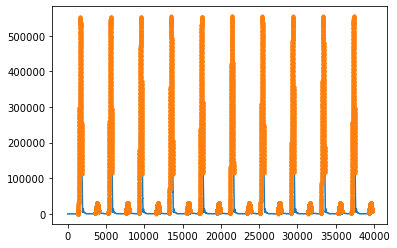

In [39]:
t = np.arange(len(y))
plt.figure()
plt.plot(t,y)
plt.plot(t[signals==1], y[signals==1],'.')

In [ ]:
settings.influence

In [ ]:
settings.lag

In [ ]:
history.length

In [ ]:
history.avg

In [ ]:
history.std2

In [ ]:
filteredY.std()**2

In [ ]:
x.shape

In [ ]:
fd = open("peak_mark.h",'r')
cdefs = fd.read()
fd.close()

In [ ]:
print(f)

In [ ]:
ffibuilder.cdef("""
    
    typedef struct {
        int x;
        int y;
    } T;

    typedef struct {
        int lag;
        double threshold;
        double influence;
    } settings_t;

    
    typedef struct {
        double avg;
        double std2;
        int start;
        int length;
        int pkidx;
        double pk;
    } history_t;
    
    double test_cos(double x);
    void test(T *t);
    void peakMark(double *y, int N, settings_t *settings, history_t *history, double *filteredY, double *signal, double *debug);
    
""")


In [ ]:
ffibuilder = FFI()
ffibuilder.set_source("_test",
   r""" // passed to the real C compiler,
        // contains implementation of things declared in cdef()
        #include <math.h>

        double test_cos(double x) {
            return cos(x);
        }
        
        #define RING_SIZE 512
  
     typedef struct {
        int x;
        int y;
    } T;
     
        void test(T *t) {
            t[0].x += 2;
        }
    
    typedef struct {
        int lag;
        double threshold;
        double influence;
    } settings_t;
    
    typedef struct {
        double avg;
        double std2;
        int start;
        int length;
        int pkidx;
        double pk;
    } history_t;
    
    double square(double x) {
        return x * x;
    }
    
    void peakMark(double *y, int N, settings_t *settings, history_t *history, double *filteredY, double *signal, double *debug) {
        double avgFilter = history->avg;
        double std2 = history->std2;
        double prevAvg, stdFilter;
        double oldValue;
        int lag = settings->lag;
        double influence = settings->influence;
        double threshold = settings->threshold;
        int start = history->start;
        int length = history->length;
        int pk_idx = history->pkidx;
        double pk = history->pk;
        
        for (int i=0; i<N; i++) {
            prevAvg = avgFilter;
            oldValue = filteredY[i%lag];
            stdFilter = sqrt(std2);
            // debug
            debug[i] = fabs(y[i] - avgFilter);
            if ((fabs(y[i] - avgFilter) > threshold * stdFilter) && (i>=lag)) {
                if (y[i] > avgFilter) {
                    signal[i] = 1;
                    if (start<0) {
                        start = i; length = 1;
                    } else {
                        length += 1;
                    }
                    if (y[i]>pk) {
                        pk = y[i]; pk_idx = i;
                    }
                }
                filteredY[i%lag] = influence * y[i] + (1 - influence) * filteredY[(i-1)%lag];
            } else {
                signal[i] = 0;
                filteredY[i%lag] = y[i];
                if (start>0) {
                    // pks.append([start, length, pk_idx, pk])
                    start = -1;
                    length = 0;
                    pk_idx = -1;
                    pk = -1;
                }
            }
            // update avg and std
            prevAvg = avgFilter;
            avgFilter = avgFilter + (filteredY[i%lag] - oldValue) / lag;
            std2 = std2 + (filteredY[i%lag] - oldValue)*(filteredY[i%lag] + oldValue - avgFilter - prevAvg) /lag;

        }
        // signal[0] = settings->influence;
        history->avg = avgFilter;
        history->std2 = std2;
    }
    
    """,
    libraries=['m'])   # or a list of libraries to link with
    # (more arguments like setup.py's Extension class:
    # include_dirs=[..], extra_objects=[..], and so on)

# cdef() expects a single string declaring the C types, functions and
# globals needed to use the shared object. It must be in valid C syntax.

fd = open("peak_mark.h",'r')
cdefs = fd.read()
fd.close()
ffibuilder.cdef(cdefs)



ffibuilder.compile(verbose=True)
